In [1224]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class Som:
    def __init__(self,x,y,input_len,sigma=1.0,learning_rate=0.5,random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        self.weights = array([v/linalg.norm(v) for v in self.weights]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self,x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x,self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index]) # || x - w ||
            it.iternext()

    def activate(self,x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self,c,sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0],2)/d)
        ay = exp(-power(self.neigy-c[1],2)/d)
        return outer(ax,ay) # the external product gives a matrix

    def diff_gaussian(self,c,sigma):
        """ Mexican hat centered in c (unused) """
        xx,yy = meshgrid(self.neigx,self.neigy)
        p = power(xx-c[0],2) + power(yy-c[1],2)
        d = 2*pi*sigma*sigma
        return exp(-(p)/d)*(1-2/d*p)

    def winner(self,x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(),self.activation_map.shape)

    def update(self,x,win,t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        # eta(t) = eta(0) / (1 + t/T) 
        # keeps the learning rate nearly constant for the first T iterations and then adjusts it
        eta = self.learning_rate/(1+t/self.T)
        sig = self.sigma/(1+t/self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win,sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])            
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self,data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i,x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q


    def random_weights_init(self,data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[int(self.random_generator.rand()*len(data)-1)]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self,data,num_iteration):        
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)        
        for iteration in range(num_iteration):
            rand_i = int(round(self.random_generator.rand()*len(data)-1)) # pick a random sample
            self.update(data[rand_i],self.winner(data[rand_i]),iteration)

    def train_batch(self,data,num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx],self.winner(data[idx]),iteration)
            iteration += 1

    def _init_T(self,num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2 # keeps the learning rate nearly constant for the first half of the iterations

    def distance_map(self):
        """ Returns the average distance map of the weights.
            (Each mean is normalized in order to sum up to 1) """
        um = zeros((self.weights.shape[0],self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1,it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1,it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii,jj,:]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self,data):
        """ 
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0],self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self,data):
        """ 
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.            
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self,data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal

class TestSom:
    def setup_method(self, method):
        self.som = Som(5,5,1)
        for w in self.som.weights: # checking weights normalization
            assert_almost_equal(1.0,linalg.norm(w))
        self.som.weights = zeros((5,5)) # fake weights
        self.som.weights[2,3] = 5.0
        self.som.weights[1,1] = 2.0

    def test_fast_norm(self):
        assert fast_norm(array([1,3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2,2),1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0,2.0])
        assert winners[(2,3)][0] == 5.0
        assert winners[(1,1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0,2.0])
        assert response[2,3] == 1
        assert response[1,1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)
     
    def test_quantization_error(self):
        self.som.quantization_error([5,2]) == 0.0
        self.som.quantization_error([4,1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4,2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        assert_array_almost_equal(som1.weights,som2.weights) # same initialization
        data = random.rand(100,2)
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som1.train_random(data,10)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights) # same state after training

    def test_train_batch(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_batch(data,10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_random(data,10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = Som(2,2,2,random_seed=1)
        som.random_weights_init(array([[1.0,.0]]))
        for w in som.weights:
            assert_array_equal(w[0],array([1.0,.0]))

In [1225]:
import itertools
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [1226]:
def count_kmers(read, k):
    """Count kmer occurrences in a given read.

    Parameters
    ----------
    read : string
        A single DNA sequence.
    k : int
        The value of k for which to count kmers.

    Returns
    -------
    counts : dictionary, {'string': int}
        A dictionary of counts keyed by their individual kmers (strings
        of length k).

    Examples
    --------
    >>> count_kmers("GATGAT", 3)
    {'ATG': 1, 'GAT': 2, 'TGA': 1}
    """
    # Start with an empty dictionary
    counts = {}
    nucleotides = ['A', 'T', 'G', 'C']
    # Add the kmer to the dictionary if it's not there
    for i in itertools.product(nucleotides, repeat=k):
        counts["".join(i)] = 0
    # Calculate how many kmers of length k there are
    num_kmers = len(read) - k + 1
    # Loop over the kmer start positions
    for kmer in window(read, n=k):
        kmer = "".join(kmer)
        if kmer not in counts:
            continue
        # Increment the count for this kmer
        counts[kmer] += 1
    # Return the final counts
    return counts

In [1227]:
count_kmers("AATCGC", 2)

{'AA': 1,
 'AT': 1,
 'AG': 0,
 'AC': 0,
 'TA': 0,
 'TT': 0,
 'TG': 0,
 'TC': 1,
 'GA': 0,
 'GT': 0,
 'GG': 0,
 'GC': 1,
 'CA': 0,
 'CT': 0,
 'CG': 1,
 'CC': 0}

# RUN

In [1381]:
import Bio.SeqIO as SeqIO
from tqdm import tqdm
import itertools 
import random

L = 1000
data_tmp = {}
ctg_index = {}
with open("./lviola.fa", "r") as f:
    for record in tqdm(SeqIO.parse(f, "fasta")):
        for i, p in enumerate(range(0, int(len(record.seq)/L)*L, L)):
            data_tmp[f"{record.id}_{i}"] = str(record.seq[p:p+L]).upper()
            if record.id not in ctg_index.keys(): ctg_index[record.id] = []
            ctg_index[record.id].append(i)

401it [00:02, 151.38it/s]


In [1359]:
K = 4
kmer_datas = []

for k, v in tqdm(data.items()):
    kmer_data = list(count_kmers(v, K).values())
    assert len(kmer_data) == 4**K
    kmer_datas.append(kmer_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119144/119144 [00:47<00:00, 2499.26it/s]


In [1360]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(kmer_datas)

cnt = 1
som = Som(2, 2, 4**K, sigma=.001,learning_rate=0.5)
while som.distance_map().T.min() < 0.9:
    print(f"{cnt} trial")
    som = Som(2, 2, 4**K, sigma=.001,learning_rate=0.5)
    #som = Som(2, 1, 4**K, sigma=.001,learning_rate=0.5)
    som.random_weights_init(X)

    som.train_random(X, 10000)
    #som.train_batch(X, 10000)
    cnt+=1

In [1361]:
som.distance_map().T

array([[0.94307011, 1.        ],
       [0.90897676, 0.99355124]])

In [1362]:
#change = {(0,0) : -1-1j, (0,1): -1+1j, (1,0): 1-1j, (1,1): 1+1j}
change = {(0,0) : 1, (0,1): -1, (1,0): 1j, (1,1): -1j}

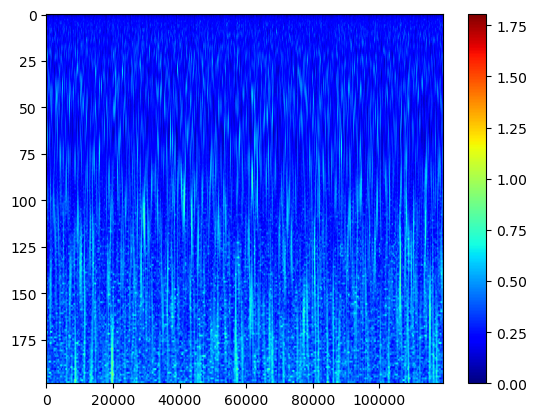

In [1368]:
raw_spec = [change[som.winner(i)] for i in X]
# raw_spec= [sum(som.winner(i)) for i in X]
import numpy as np
raw_spec = np.array(raw_spec)
start = 1
D = len(raw_spec)
M = 200
cwtmatr, freqs = pywt.cwt(raw_spec[1+start:D+start], list(range(1, M)), 'cmor4-1.0')
plt.imshow(np.absolute(cwtmatr),  cmap='jet', aspect='auto',vmax=np.absolute(cwtmatr).max(), vmin=0) 
#plt.plot(np.angle(raw_spec[1+start:D+start])/1.57)
#plt.plot([1+start:100+start])
plt.colorbar()
plt.show() 

In [ ]:
def heuristic():
    ma = 0
    for i in tqdm(range(1000)):
        random.seed(i)
        random.shuffle(raw_spec)
        cwtmatr, freqs = pywt.cwt(raw_spec[1+start:D+start], list(range(1, 50)), 'cmor4-1.0')
        if ma < np.absolute(np.max(cwtmatr)):
            ma = np.absolute(np.max(cwtmatr))
            best = cwtmatr
    plt.imshow(np.absolute(best),  cmap='jet', aspect='auto',vmax=np.absolute(best).max(), vmin=0) 
    plt.colorbar()
    plt.show()
heuristic()

 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 395/1000 [05:54<09:03,  1.11it/s]

# TMP

In [1292]:
from itertools import chain
from math import sqrt

def divisors(n, M):
    return sorted([x for x in chain.from_iterable((i,n//i) for i in range(1,int(sqrt(n))+1) if n%i == 0) if x < M])

1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:00<00:00, 415.81it/s]


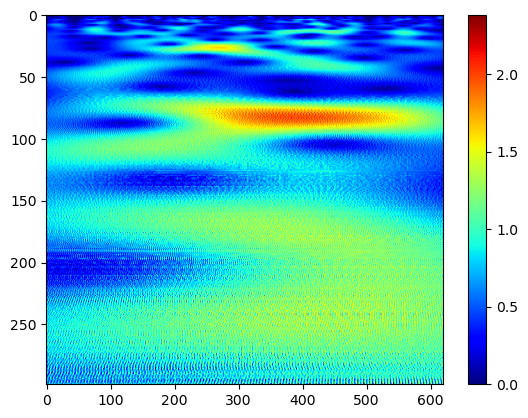

In [1325]:
from tqdm import tqdm
import sys
raw_spec = [change[som.winner(i)] for i in X]
raw_spec = np.array(raw_spec)

def E_step(matrix):
    return np.argmax(np.max(np.absolute(matrix), axis=0))

def M_step(matrix, M, i):
    try: 
        return np.argmax(np.absolute(matrix)[divisors(np.argmax(np.max(np.absolute(matrix), axis=0)), M)[-i-2]])
    except IndexError:
        return np.nan

def change_spec(spec, matrix, M, i):
    tmp = spec[E_step(matrix)]
    try:
        spec[E_step(matrix)] = spec[M_step(matrix, M, i)]
    except IndexError:
        return np.nan
    spec[M_step(matrix, M, i)] = tmp

def rendering(spec, M=50, start=1):
    D = len(spec)
    cwtmatr, freqs = pywt.cwt(spec[1+start:D+start], list(range(1, M)), 'cmor4-1.0')
    cnt = 0
    for i in tqdm(range(100000)):
        if change_spec(spec=spec, matrix=cwtmatr, M=M, i=i) == np.nan:
            break
        change_spec(spec=spec, matrix=cwtmatr, M=M, i=i)
        cnt +=1
    plt.imshow(np.absolute(cwtmatr),  cmap='jet', aspect='auto',vmax=np.absolute(cwtmatr).max(), vmin=0) 
    plt.colorbar()
    plt.show()
print(cnt)
rendering(raw_spec, M=300)

# Legacy

In [542]:
fft = np.fft.fft(raw_spec) / len(raw_spec)  
 
fft_magnitude = abs(fft)
shift = np.fft.fftshift(fft_magnitude)

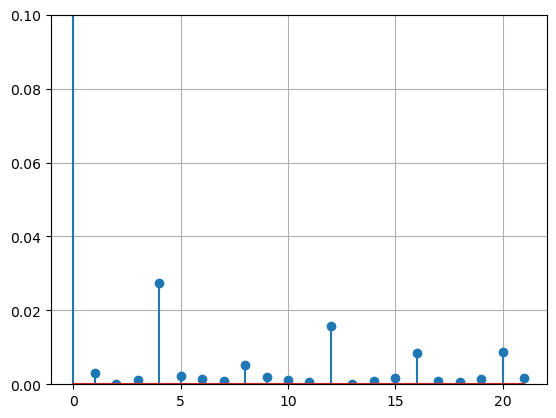

In [543]:
length = len(raw_spec)

fs = length
f = np.round(np.linspace(-(fs / 2), fs / 2, length)[int(length/2):int(length/2)+22])
 
plt.stem(f, shift[int(length/2):int(length/2)+22]) 

plt.ylim(0,0.1)
plt.grid()

plt.savefig("./ecolidouble.jpg")
plt.show()

In [544]:
print(sorted(shift, reverse=True)[:10])
print([i for i in list(map(lambda x: x - length // 2 + 1, reversed(np.argsort(shift)))) if i > 0][:10]) 
print([(length // i)*L for i in list(map(lambda x: x - length // 2 + 1, reversed(np.argsort(shift)))) if i > 0][:10]) 

[1.3169770679555541, 0.027487824973584894, 0.027487824973584887, 0.02348633662720106, 0.02348633662720105, 0.02272254001623008, 0.02272254001623008, 0.022171102117552972, 0.02217110211755297, 0.021893224402072118]
[1, 5, 209, 137, 237, 449, 169, 401, 413, 557]
[19034500, 3806900, 91000, 138900, 80300, 42300, 112600, 47400, 46000, 34100]


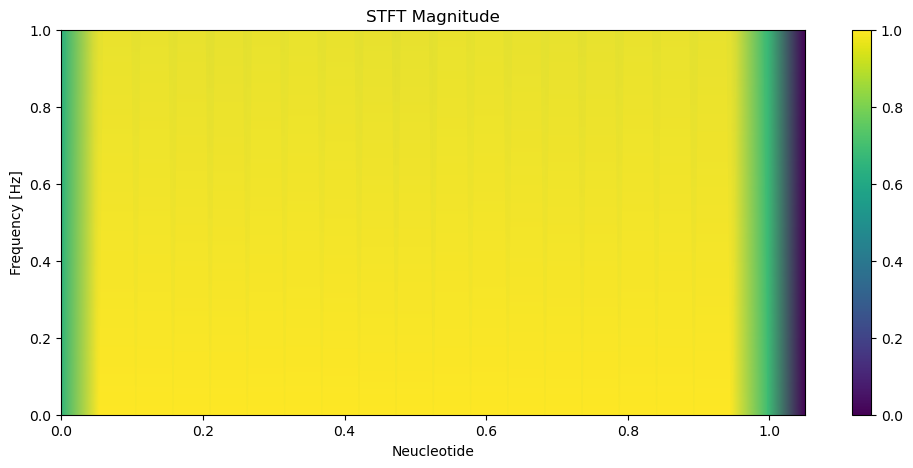

In [555]:
from scipy import signal

def draw_stft(f, t, Zxx):
    plt.figure(figsize=(12,5))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
    plt.title('STFT Magnitude'); plt.ylabel('Frequency [Hz]')
    plt.colorbar()
    plt.xlabel('Neucleotide'); plt.ylim([0, 1]); plt.show()

def calc_stft(nperseg):
    f, t, Zxx = signal.stft(raw_spec, length, nperseg=nperseg)
    draw_stft(f, t, Zxx)

calc_stft(20000)

In [490]:
signal.stft(raw_spec, length, nperseg=100) # f, t, Zxx

(array([     0.  ,    951.72,   1903.44,   2855.16,   3806.88,   4758.6 ,
          5710.32,   6662.04,   7613.76,   8565.48,   9517.2 ,  10468.92,
         11420.64,  12372.36,  13324.08,  14275.8 ,  15227.52,  16179.24,
         17130.96,  18082.68,  19034.4 ,  19986.12,  20937.84,  21889.56,
         22841.28,  23793.  ,  24744.72,  25696.44,  26648.16,  27599.88,
         28551.6 ,  29503.32,  30455.04,  31406.76,  32358.48,  33310.2 ,
         34261.92,  35213.64,  36165.36,  37117.08,  38068.8 ,  39020.52,
         39972.24,  40923.96,  41875.68,  42827.4 ,  43779.12,  44730.84,
         45682.56,  46634.28, -47586.  , -46634.28, -45682.56, -44730.84,
        -43779.12, -42827.4 , -41875.68, -40923.96, -39972.24, -39020.52,
        -38068.8 , -37117.08, -36165.36, -35213.64, -34261.92, -33310.2 ,
        -32358.48, -31406.76, -30455.04, -29503.32, -28551.6 , -27599.88,
        -26648.16, -25696.44, -24744.72, -23793.  , -22841.28, -21889.56,
        -20937.84, -19986.12, -19034.4

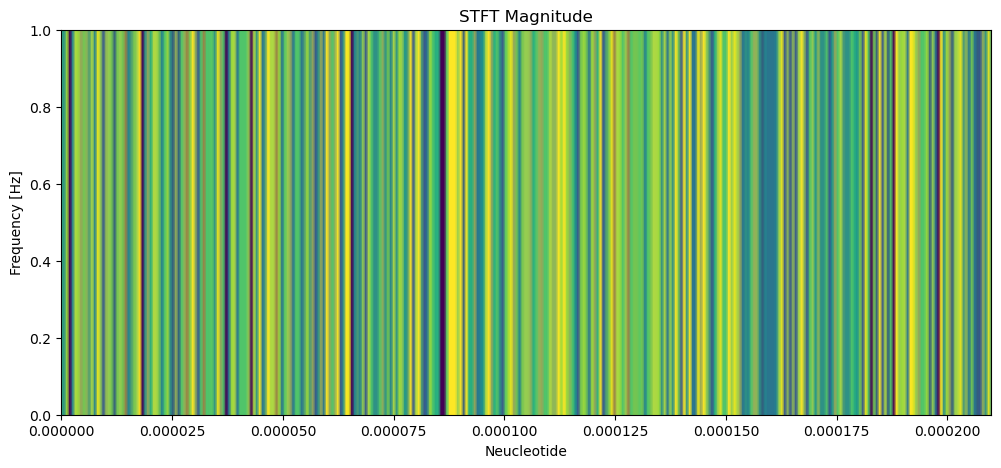

In [468]:
from scipy import signal

def draw_stft(f, t, Zxx):
    plt.figure(figsize=(12,5))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
    plt.title('STFT Magnitude'); plt.ylabel('Frequency [Hz]')
    plt.xlabel('Neucleotide'); plt.ylim([0, 1]); plt.show()

def calc_stft(nperseg):
    f, t, Zxx = signal.stft(raw_spec[length//2-1000:length//2], length*L, nperseg=nperseg)
    draw_stft(f, t, Zxx)

calc_stft(5)

Frequency change point estimation

In [74]:
#print(kmer_datas[0])

# Transcriptome data

In [209]:
import pandas as pd

X = pd.read_csv("./RSEM.isoform.TMM.EXPR.matrix", sep="\t", index_col=0)

In [210]:
np.shape(X)

(51125, 36)

In [212]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (1, 2))
X = sc.fit_transform(X)

#som = Som(2, 1, 4**K, sigma=.001,learning_rate=0.5)
som = Som(3, 4, 36, sigma=.02, learning_rate=0.7)
som.random_weights_init(X)

som.train_random(X, 1000)
#som.train_batch(X, 1000)

In [213]:
som.distance_map().T

array([[0.021707  , 0.28235342, 0.74757947],
       [0.17484843, 0.49042698, 0.42712805],
       [0.23915455, 1.        , 0.27354045],
       [0.1664343 , 0.23432017, 0.16660569]])

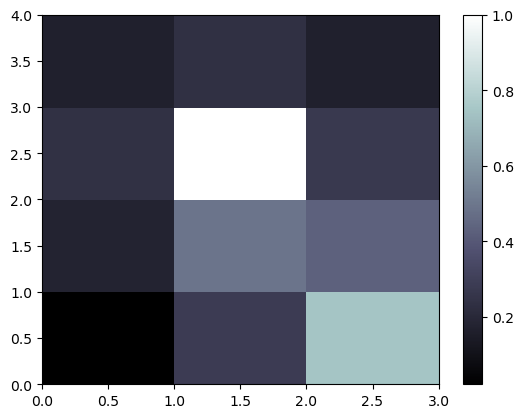

In [215]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
#y = [0, 0, 1, 1, 0]
for i, x in enumerate(X):
    w = som.winner(x)
    #print(w[0], end="\t")
    #plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', markersize = 10, markeredgewidth = 2)
show()

Os Vv Sl Nn Gm

In [77]:
data = load_digits()

In [25]:
data.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])